# Importing packages

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import ppscore as pps
from tqdm import tqdm

from scipy import signal
from scipy.fft import fft, fftfreq, ifft, fft2, ifft2
from scipy.signal import welch, butter, filtfilt


In [2]:
plt.style.use('default')

plt.rcParams.update({
    'font.size': 16,
    'axes.linewidth': 2,
    'axes.titlesize': 20,
    'axes.edgecolor': 'black',
    'axes.labelsize': 20,
    'axes.grid': True,
    'lines.linewidth': 1.5,
    'lines.markersize': 6,
    'figure.figsize': (15, 6),
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'font.family': 'Arial',
    'legend.fontsize': 13,
    'legend.framealpha': 1,
    'legend.edgecolor': 'black',
    'legend.shadow': False,
    'legend.fancybox': True,
    'legend.frameon': True,
})

In [3]:
from utils.preprocessing import *
from utils.fourier import *

# Importing dataset

In [4]:
path = './datasets/sensors'
file_names = get_file_names(folder_path=path)

File names:  ['1623535615-3006-IAJ9206.csv', '1624040490-2957-NAI1549.csv', '1624374799-3006-MYS2071.csv', '1624962426-3006-NAH4736.csv']
Number of files:  4


In [5]:
df = import_datasets(file_names,import_file_name=True)

In [6]:
df = split_columns(df, column='filename', new_col_names=['start', 'interval', 'sensor_id'])
df

,x,y,z,start,interval,sensor_id
0,-1.003174,-0.097778,-0.017334,1623535615,3006,IAJ9206.csv
1,-0.993591,-0.084778,-0.009766,1623535615,3006,IAJ9206.csv
2,-0.964844,-0.048462,0.062012,1623535615,3006,IAJ9206.csv
3,-0.868591,-0.010437,0.103577,1623535615,3006,IAJ9206.csv
4,-0.885498,-0.041992,0.078003,1623535615,3006,IAJ9206.csv
...,...,...,...,...,...,...
19915,0.096008,-0.032776,1.068115,1624962426,3006,NAH4736.csv
19916,0.075439,0.002808,1.206482,1624962426,3006,NAH4736.csv
19917,-0.041138,0.114014,0.938843,1624962426,3006,NAH4736.csv
19918,-0.066406,0.238770,1.069580,1624962426,3006,NAH4736.csv


In [7]:
df = split_columns(df, column='sensor_id', new_col_names=['sensor_id','csv'], symbol='.')
df

,x,y,z,start,interval,sensor_id,csv
0,-1.003174,-0.097778,-0.017334,1623535615,3006,IAJ9206,csv
1,-0.993591,-0.084778,-0.009766,1623535615,3006,IAJ9206,csv
2,-0.964844,-0.048462,0.062012,1623535615,3006,IAJ9206,csv
3,-0.868591,-0.010437,0.103577,1623535615,3006,IAJ9206,csv
4,-0.885498,-0.041992,0.078003,1623535615,3006,IAJ9206,csv
...,...,...,...,...,...,...,...
19915,0.096008,-0.032776,1.068115,1624962426,3006,NAH4736,csv
19916,0.075439,0.002808,1.206482,1624962426,3006,NAH4736,csv
19917,-0.041138,0.114014,0.938843,1624962426,3006,NAH4736,csv
19918,-0.066406,0.238770,1.069580,1624962426,3006,NAH4736,csv


In [8]:
df= df.drop(['csv'],axis=1)
df['interval'] = df['interval'].astype('float')
df['interval'] = df['interval']*(1e-3)
df

,x,y,z,start,interval,sensor_id
0,-1.003174,-0.097778,-0.017334,1623535615,3.006,IAJ9206
1,-0.993591,-0.084778,-0.009766,1623535615,3.006,IAJ9206
2,-0.964844,-0.048462,0.062012,1623535615,3.006,IAJ9206
3,-0.868591,-0.010437,0.103577,1623535615,3.006,IAJ9206
4,-0.885498,-0.041992,0.078003,1623535615,3.006,IAJ9206
...,...,...,...,...,...,...
19915,0.096008,-0.032776,1.068115,1624962426,3.006,NAH4736
19916,0.075439,0.002808,1.206482,1624962426,3.006,NAH4736
19917,-0.041138,0.114014,0.938843,1624962426,3.006,NAH4736
19918,-0.066406,0.238770,1.069580,1624962426,3.006,NAH4736


# Plotting FFT

In [9]:
# Sensor id
sensor_id_names = df['sensor_id'].unique()
sensor_id_names

# Dataset filtered for each sensor
df_sensor1 = df.loc[(df['sensor_id'] == sensor_id_names[0])]
df_sensor2 = df.loc[(df['sensor_id'] == sensor_id_names[1])]
df_sensor3 = df.loc[(df['sensor_id'] == sensor_id_names[2])]
df_sensor4 = df.loc[(df['sensor_id'] == sensor_id_names[3])]

# Sampling interval - seconds/sample or meters/sample
dt1 = df_sensor1.iloc[0, -2]
dt2 = df_sensor2.iloc[0, -2]
dt3 = df_sensor3.iloc[0, -2]
dt4 = df_sensor4.iloc[0, -2]


df_list = [df_sensor1, df_sensor2, df_sensor3, df_sensor4]
dt_list = [dt1, dt2, dt3, dt4]

df_sensor1

,x,y,z,start,interval,sensor_id
0,-1.003174,-0.097778,-0.017334,1623535615,3.006,IAJ9206
1,-0.993591,-0.084778,-0.009766,1623535615,3.006,IAJ9206
2,-0.964844,-0.048462,0.062012,1623535615,3.006,IAJ9206
3,-0.868591,-0.010437,0.103577,1623535615,3.006,IAJ9206
4,-0.885498,-0.041992,0.078003,1623535615,3.006,IAJ9206
...,...,...,...,...,...,...
4975,-1.015808,0.047424,0.120422,1623535615,3.006,IAJ9206
4976,-1.054077,-0.048462,-0.051331,1623535615,3.006,IAJ9206
4977,-1.090515,-0.046814,-0.054749,1623535615,3.006,IAJ9206
4978,-1.070557,-0.042114,-0.030212,1623535615,3.006,IAJ9206


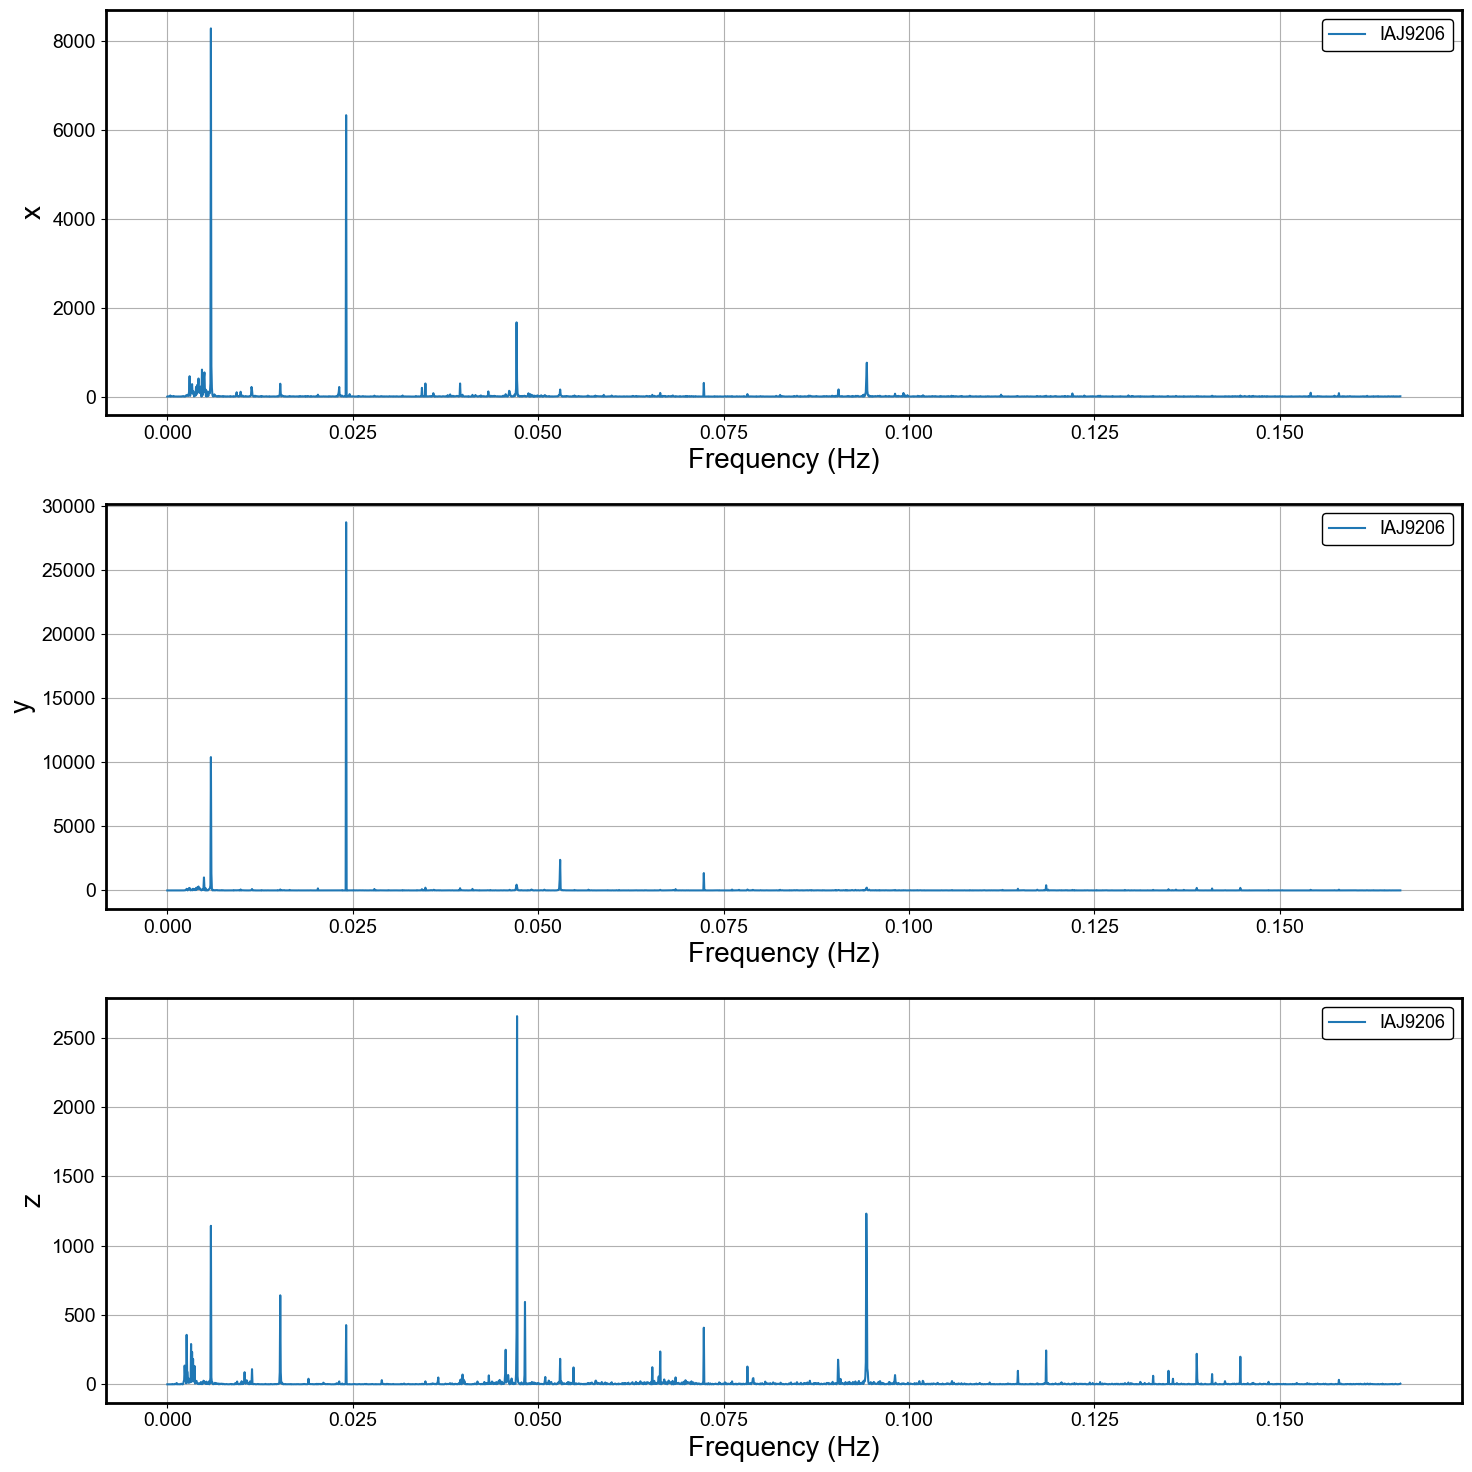

In [10]:
fig, ax, df_FFT = plot_FFT(df_list[0], dt_list[0], subset=['x', 'y', 'z'], legend=sensor_id_names[0], nrows=3, ncols=1, figsize=(15, 15))

(0.0, 250.0)

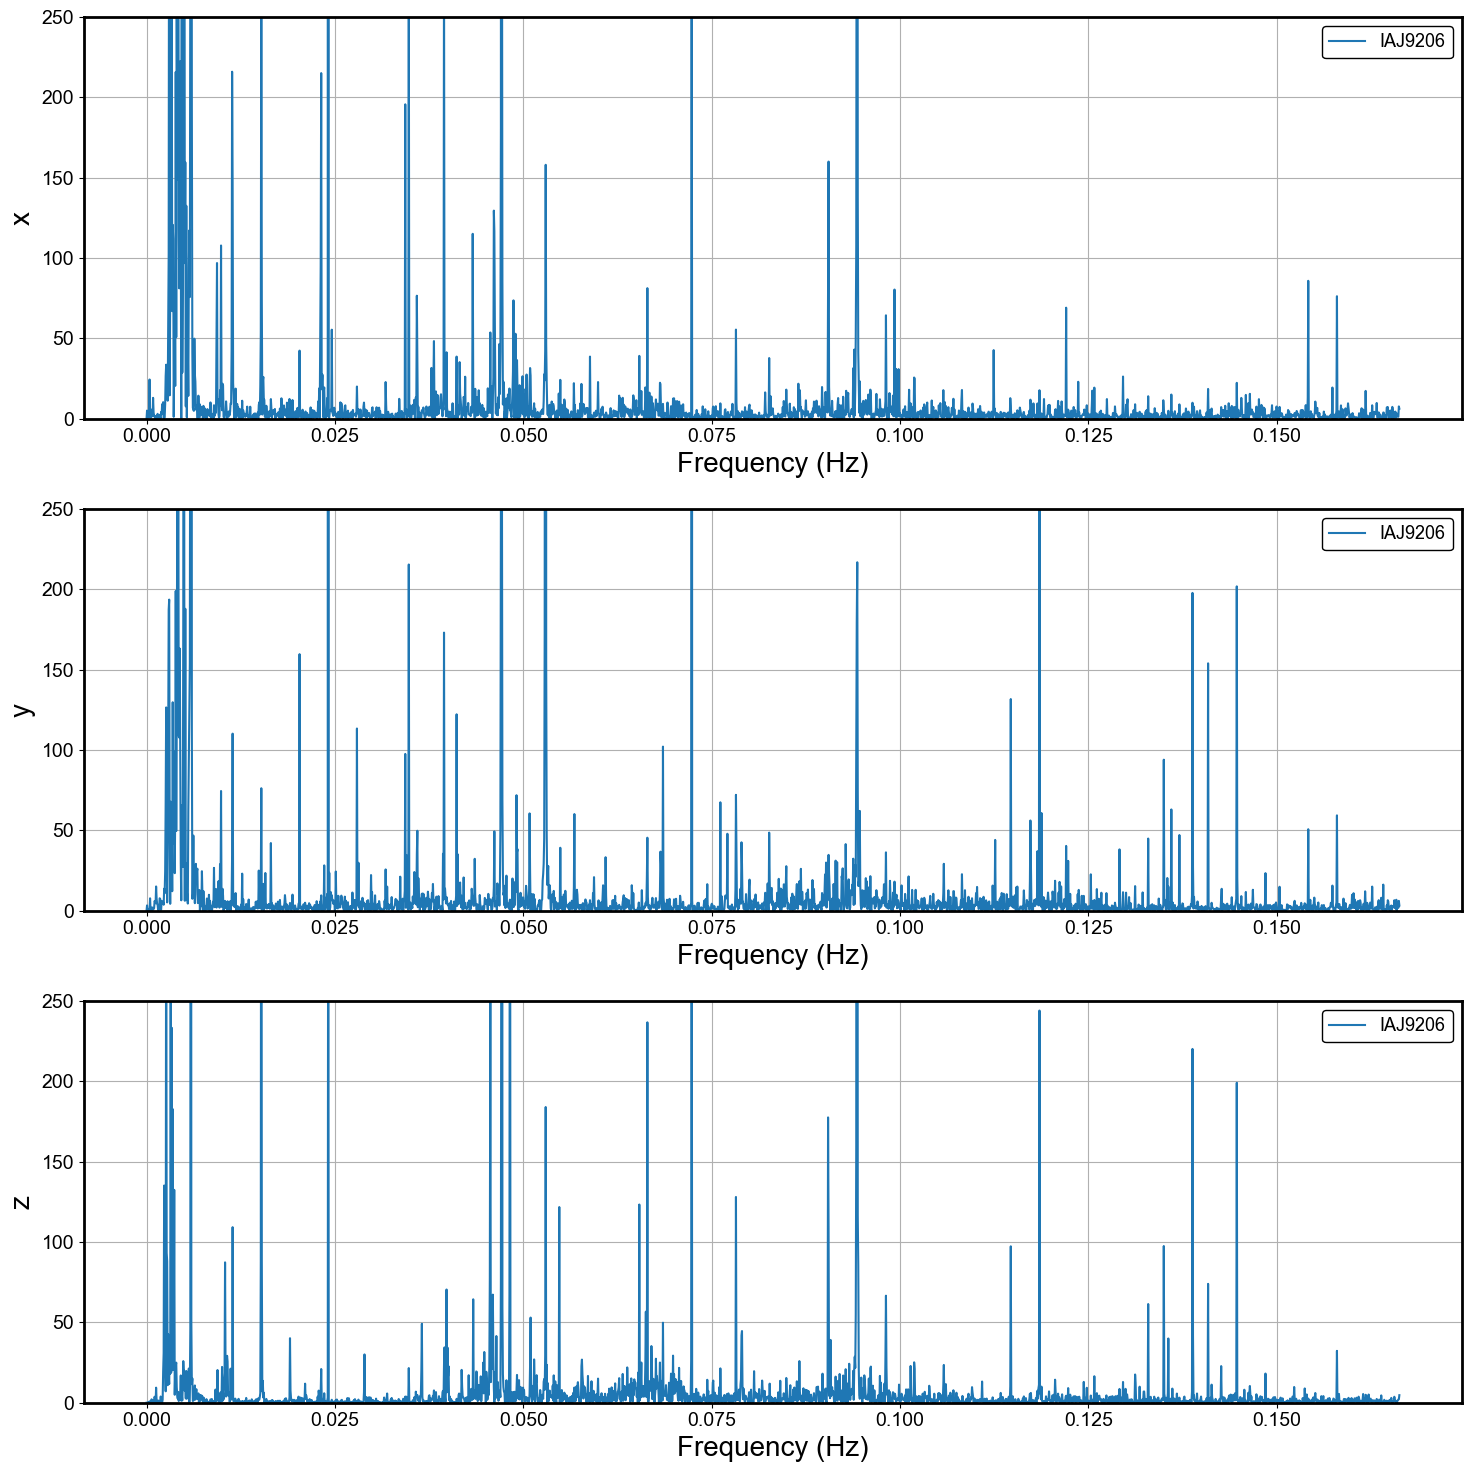

In [11]:
fig, ax, df_FFT = plot_FFT(df_list[0], dt_list[0], subset=['x', 'y', 'z'], legend=sensor_id_names[0], nrows=3, ncols=1, figsize=(15, 15))

ax[0].set_ylim([0, 250])
ax[1].set_ylim([0, 250])
ax[2].set_ylim([0, 250])

# Noise filtering

For the noise filtering step, the power of the signal is used to highlight the larger amplitudes. Since the signal is squared:

- Smaller amplitudes will increase a little
- Large amplitudes will increase by a lot. 
- Amplitude lower than 1 will decrease (very likely to be noise)

3it [00:00, 1496.01it/s]
3it [00:00, 1504.95it/s]
3it [00:00, 1504.23it/s]


(0.0, 100.0)

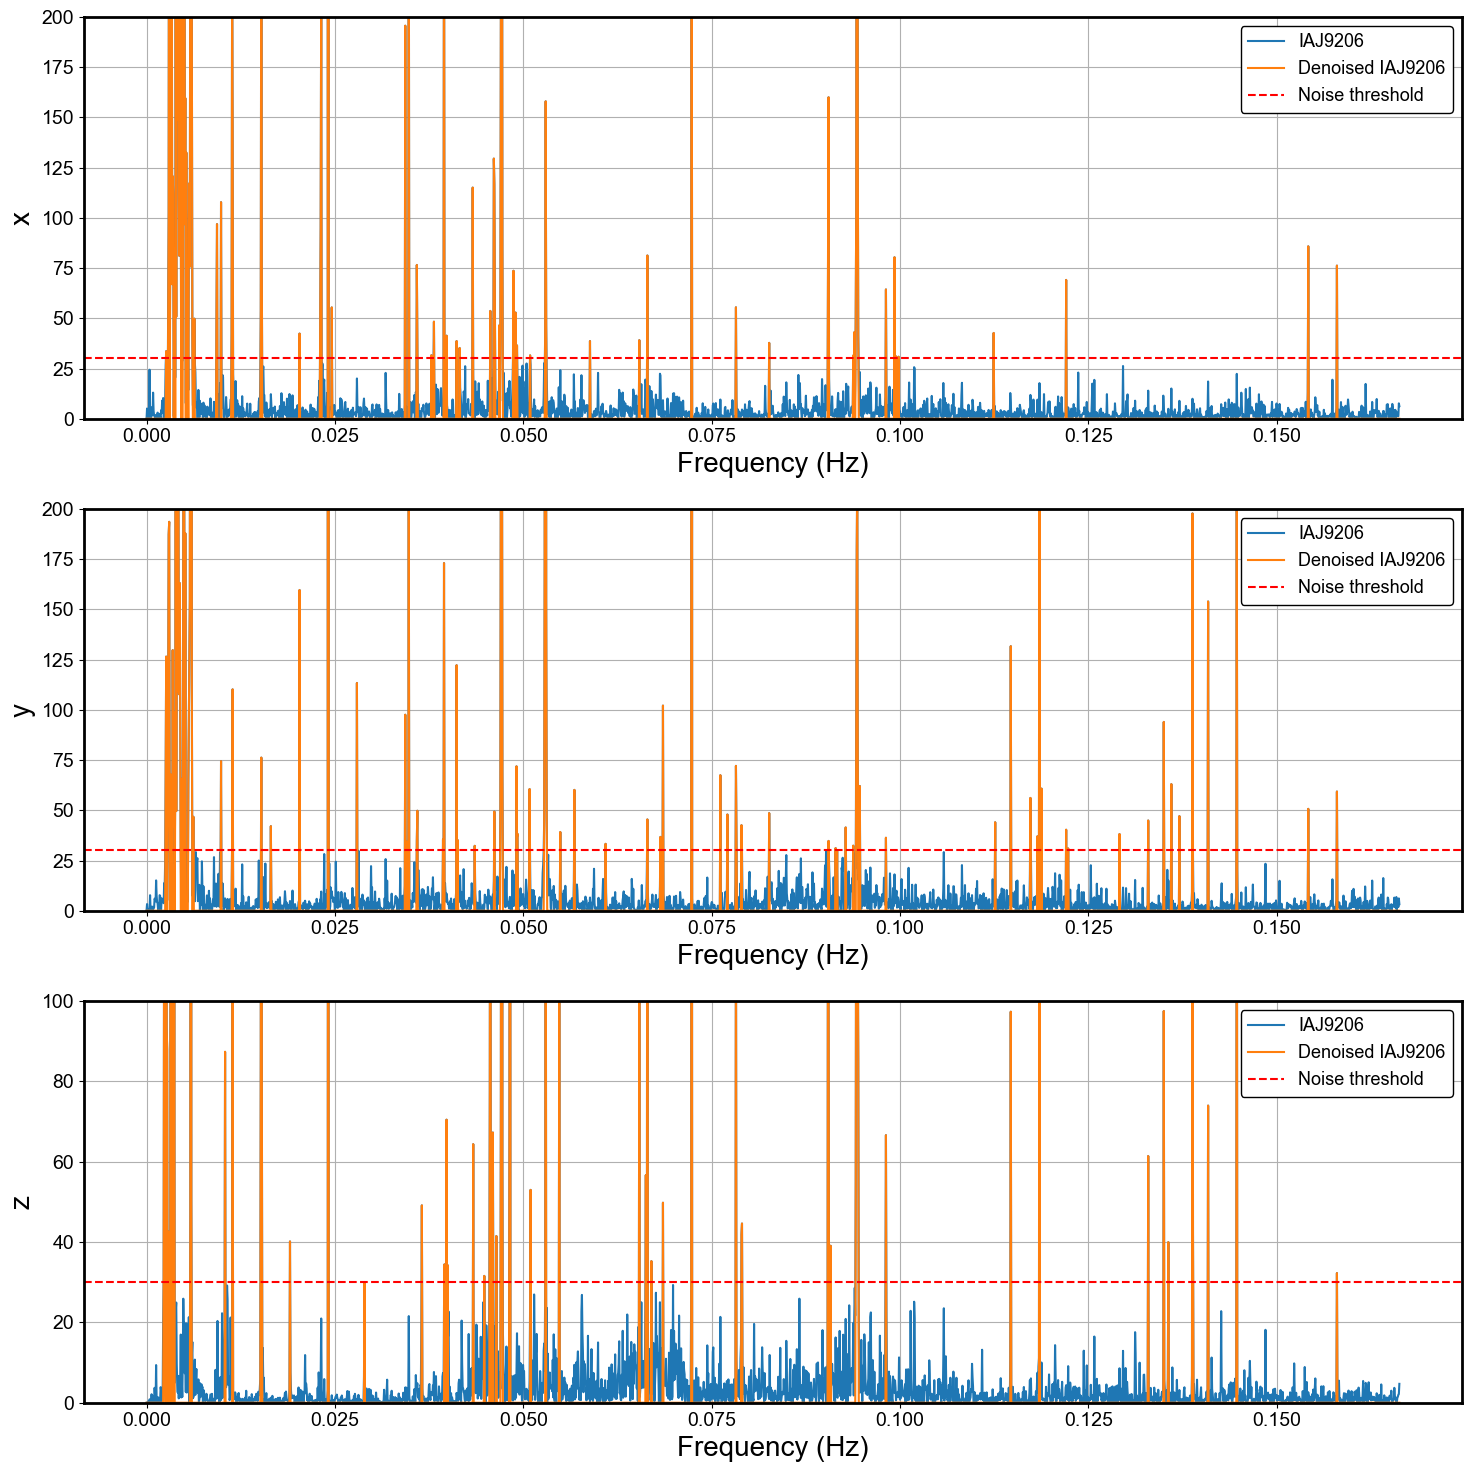

In [12]:
threshold_list = [30,30,30] 

fig, ax, df_FFT = plot_FFT(df_list[0], dt_list[0], subset=['x', 'y', 'z'], legend=sensor_id_names[0],
                           nrows=3, ncols=1, figsize=(15, 15),
                           plot_filtered=True, threshold_list=threshold_list)

ax[0].set_ylim([0, 200])
ax[1].set_ylim([0, 200])
ax[2].set_ylim([0, 100])

Now we will apply the IFFT on the denoised signal from the frequency domain to the time domain

In [13]:
df_filtered = ifft_df(df_list[0], df_FFT=df_FFT, dt=dt_list[0], subset=['x', 'y', 'z'], threshold_list=threshold_list)

3it [00:00, 1503.87it/s]


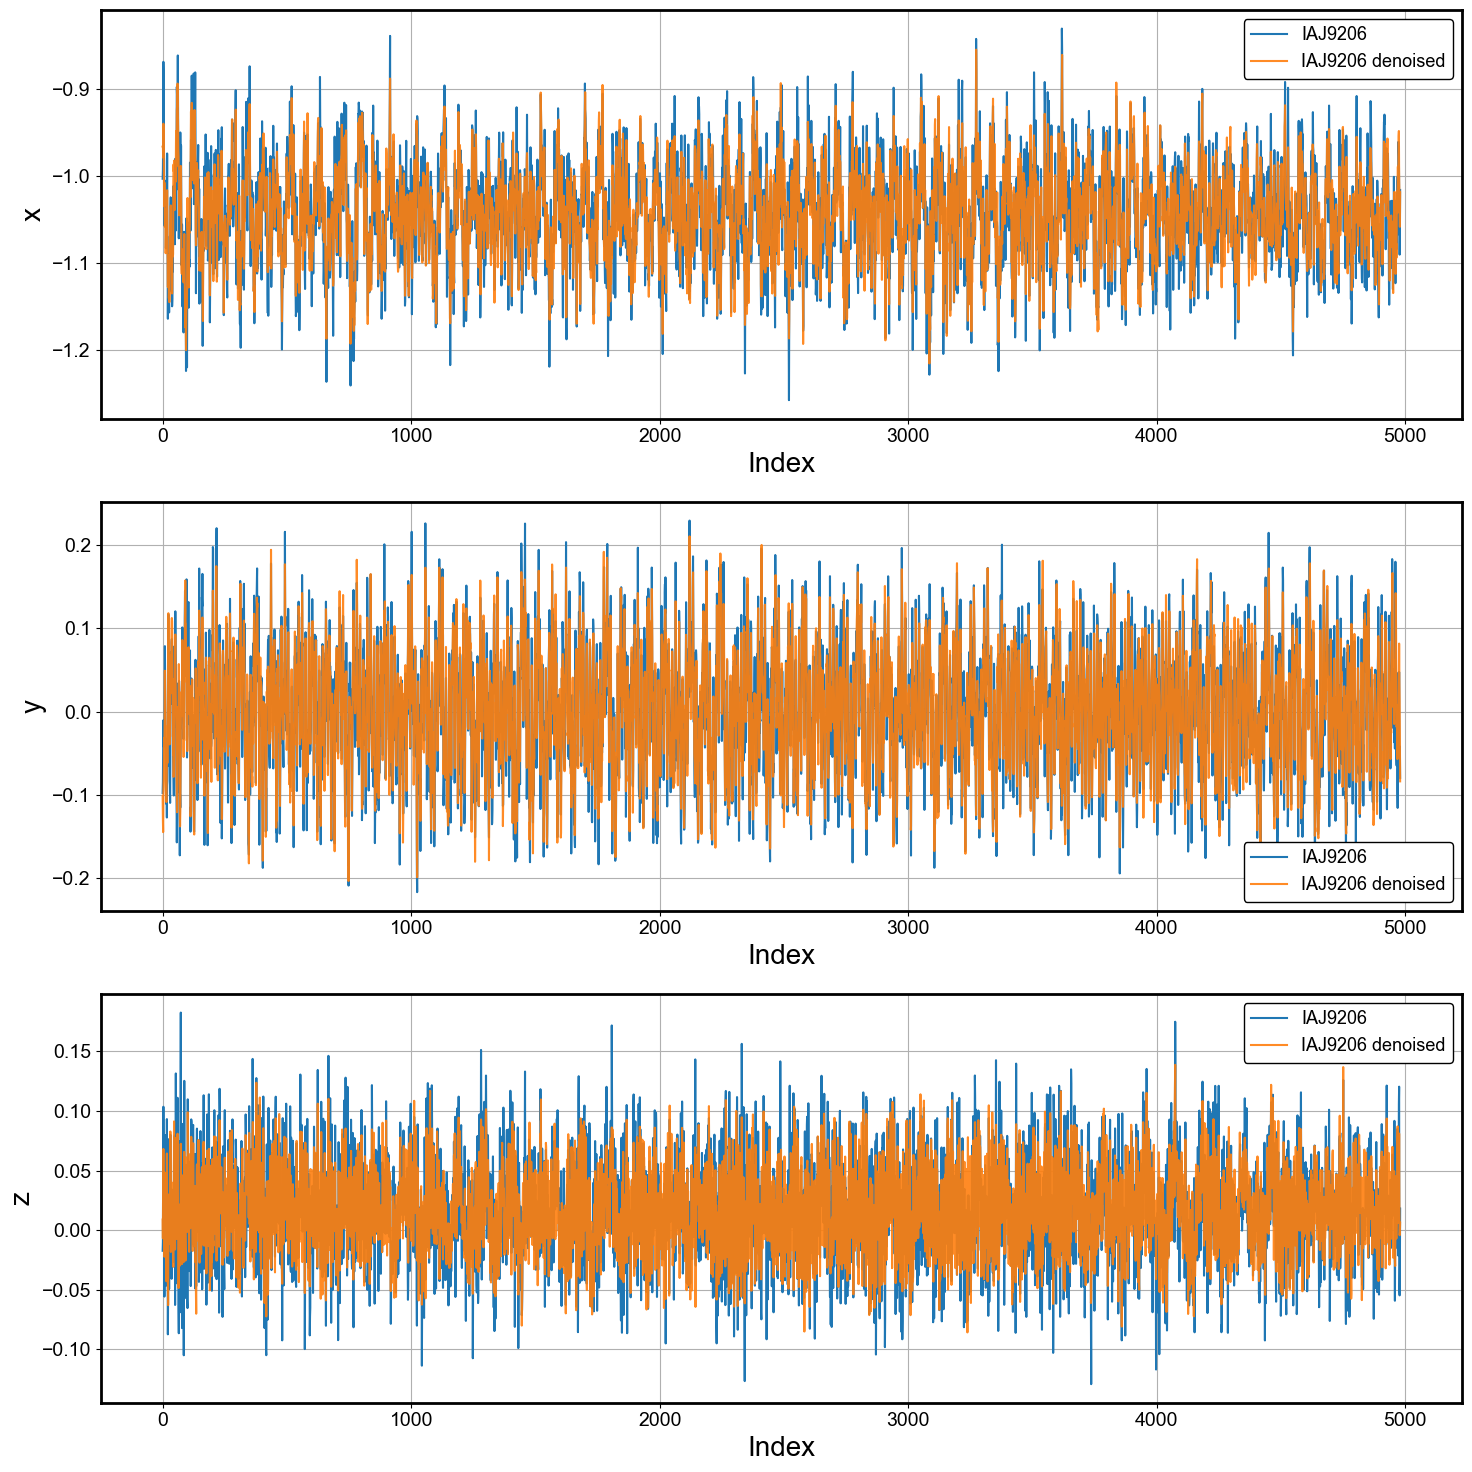

In [14]:
fig, ax = compare_filtered_unfiltered(df_sensor1, df_filtered, subset=['x', 'y', 'z'], legend = sensor_id_names[0],nrows=3, ncols=1, figsize=(15,15))

(0.0, 500.0)

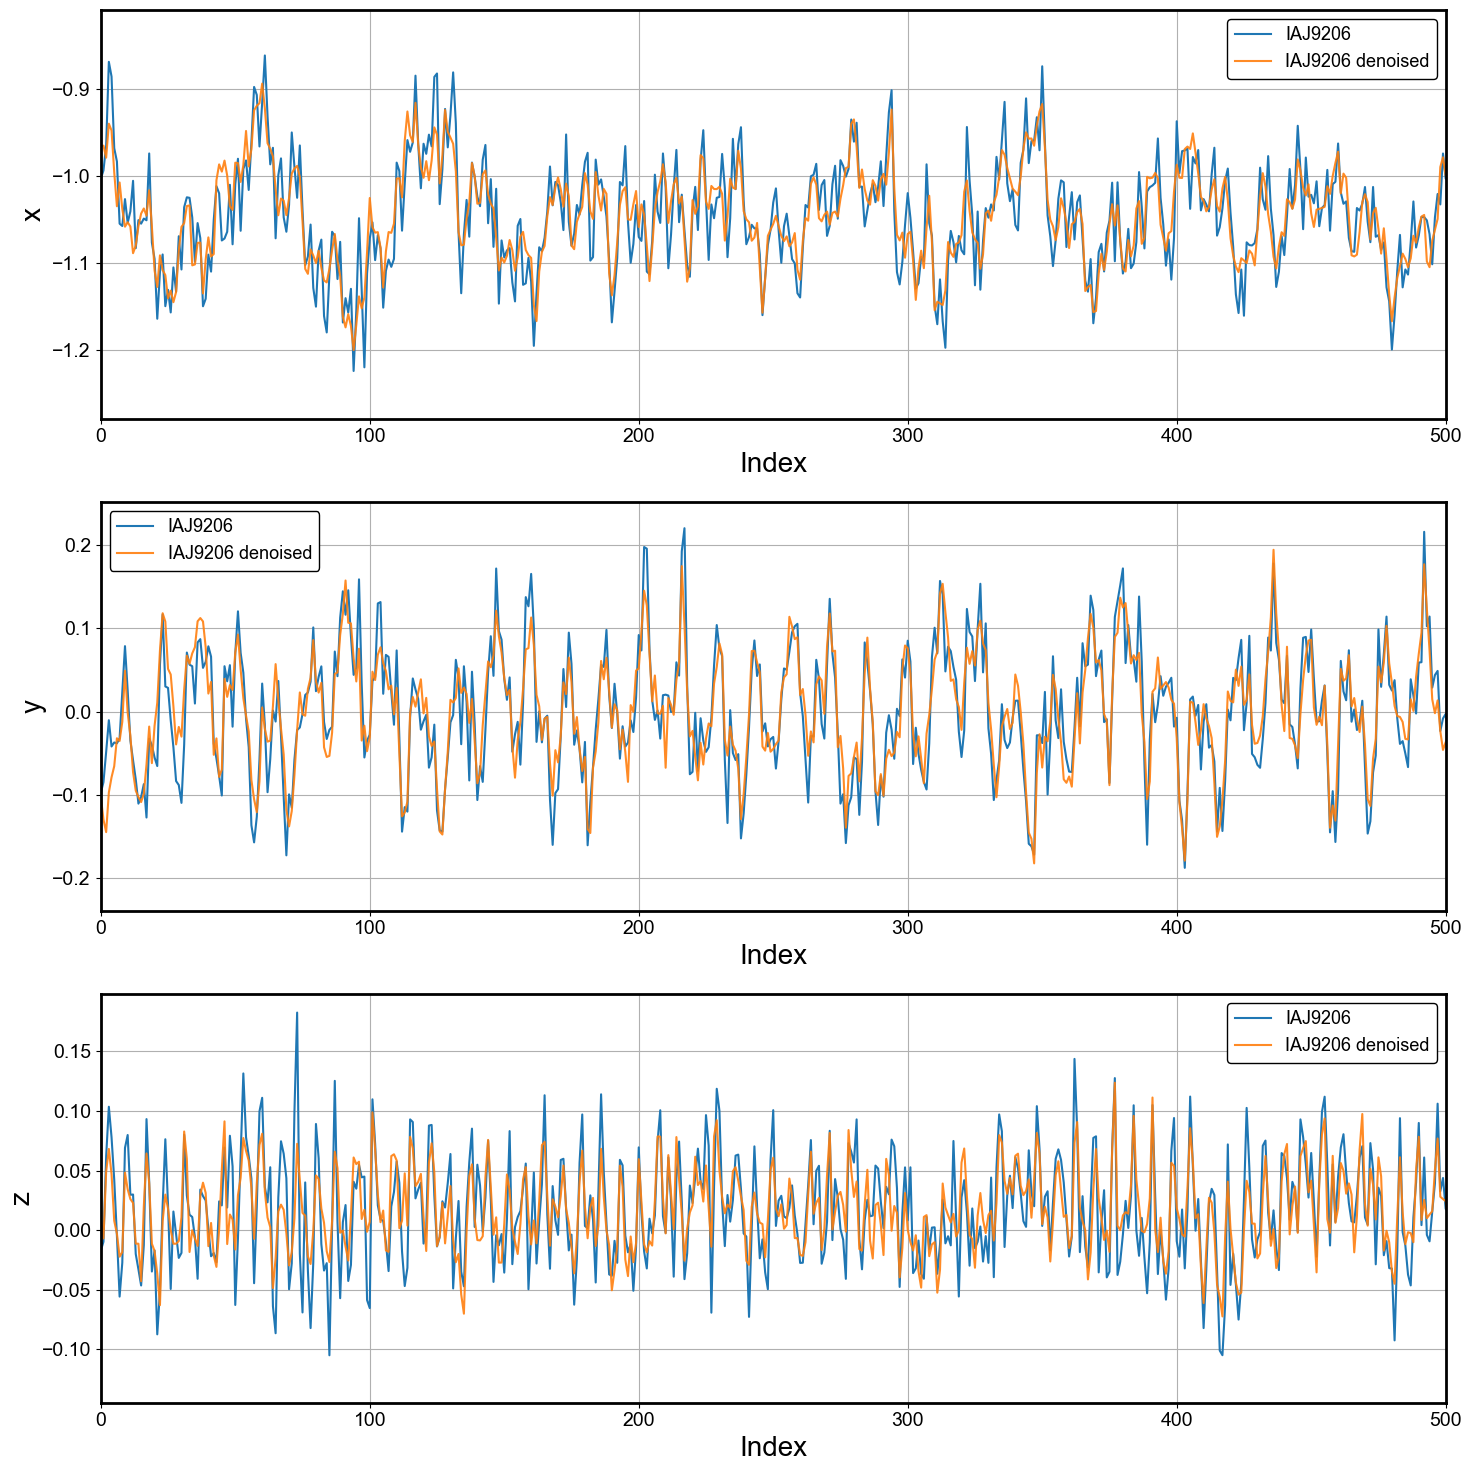

In [15]:
fig, ax = compare_filtered_unfiltered(df_sensor1, df_filtered, subset=['x', 'y', 'z'], legend=sensor_id_names[0], nrows=3, ncols=1, figsize=(15, 15))

ax[0].set_xlim([0, 500])
ax[1].set_xlim([0, 500])
ax[2].set_xlim([0, 500])

There is very little noise in the data, however, there are still a lot of oscillations that can be attributed to high frequencies. The next section will see if a Butterworth filter can solve this

# Butterworth filtering

From the previous section, we know the frequency spectrum of one of the sensors

3it [00:00, 2917.44it/s]
3it [00:00, 3005.95it/s]
3it [00:00, 1002.54it/s]


(0.0, 100.0)

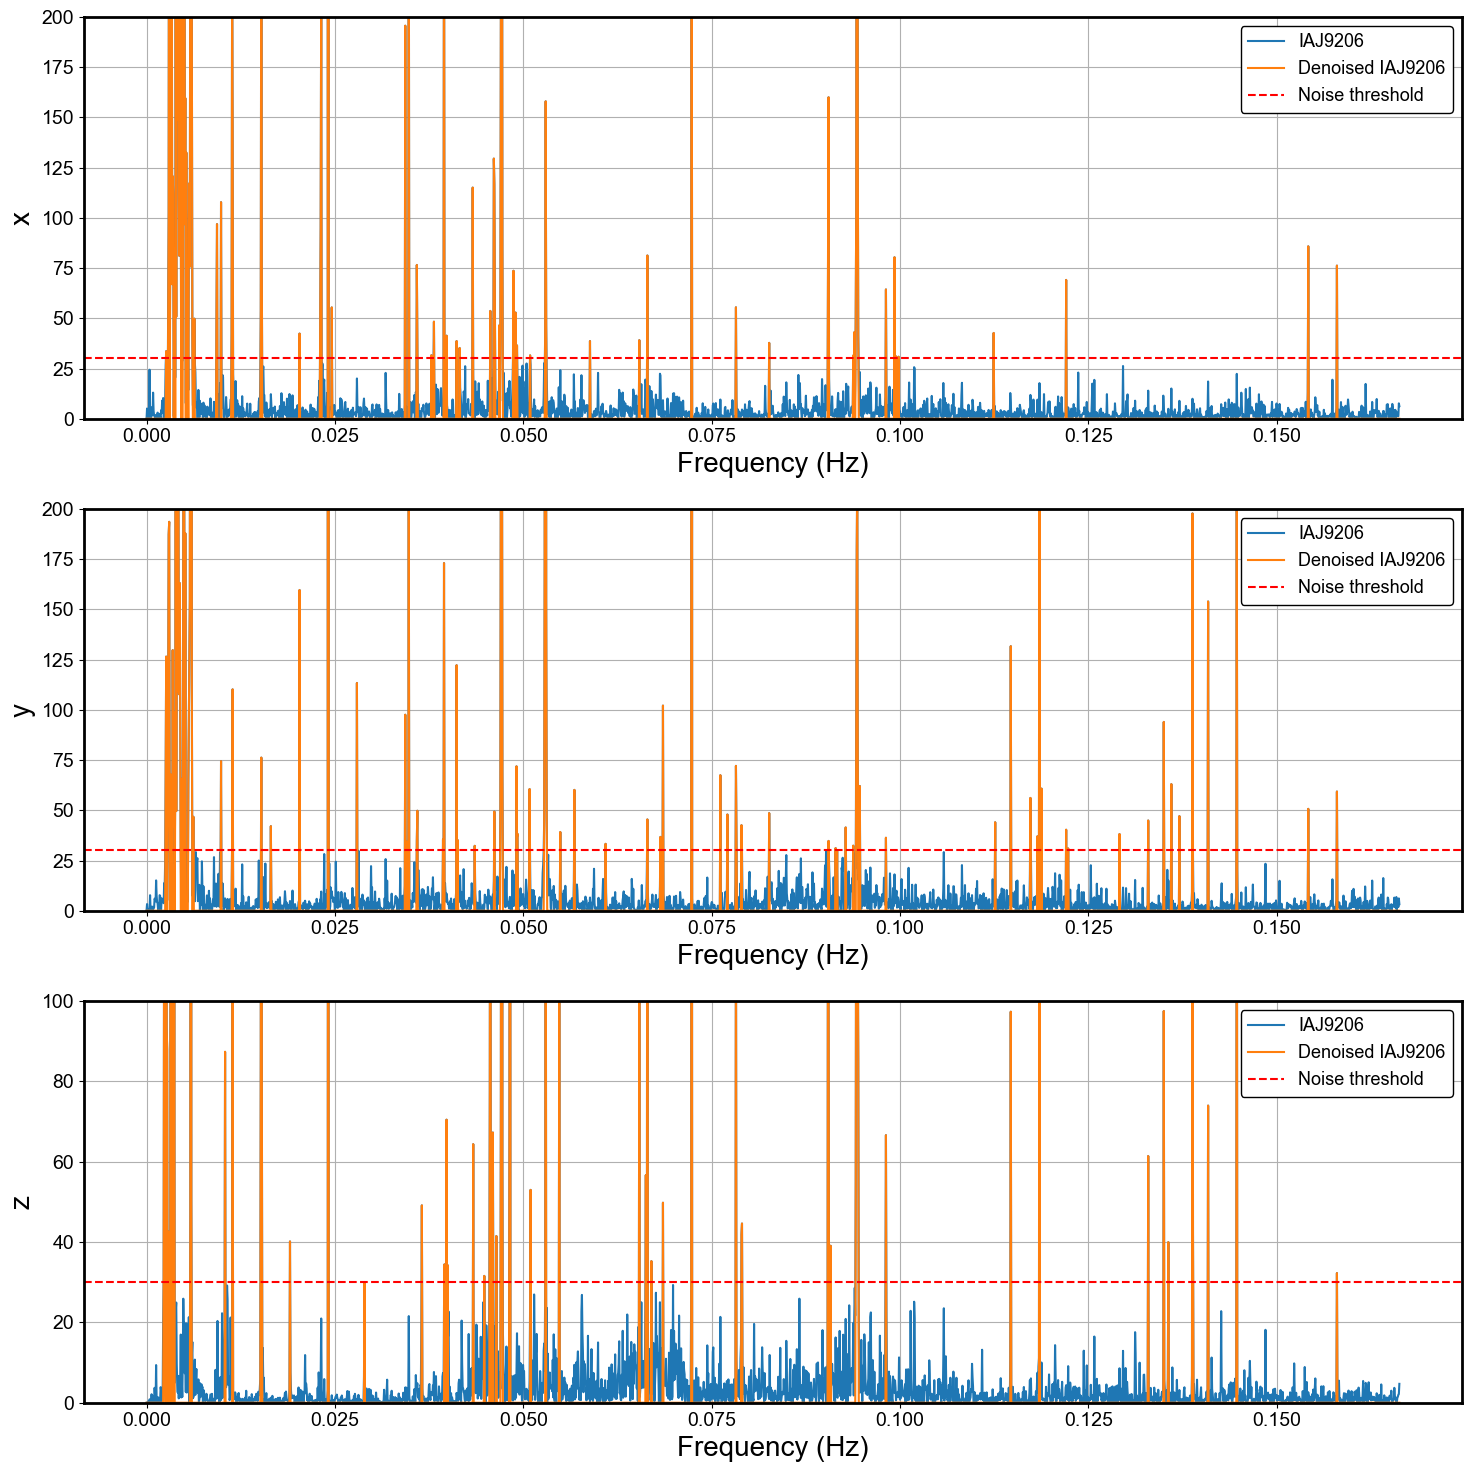

In [16]:
fig, ax, df_FFT = plot_FFT(df_list[0], dt_list[0], subset=['x', 'y', 'z'], legend=sensor_id_names[0],
                           nrows=3, ncols=1, figsize=(15, 15),
                           plot_filtered=True, threshold_list=threshold_list)

ax[0].set_ylim([0, 200])
ax[1].set_ylim([0, 200])
ax[2].set_ylim([0, 100])

We will use a low pass butterworth filter to remove high frequency components

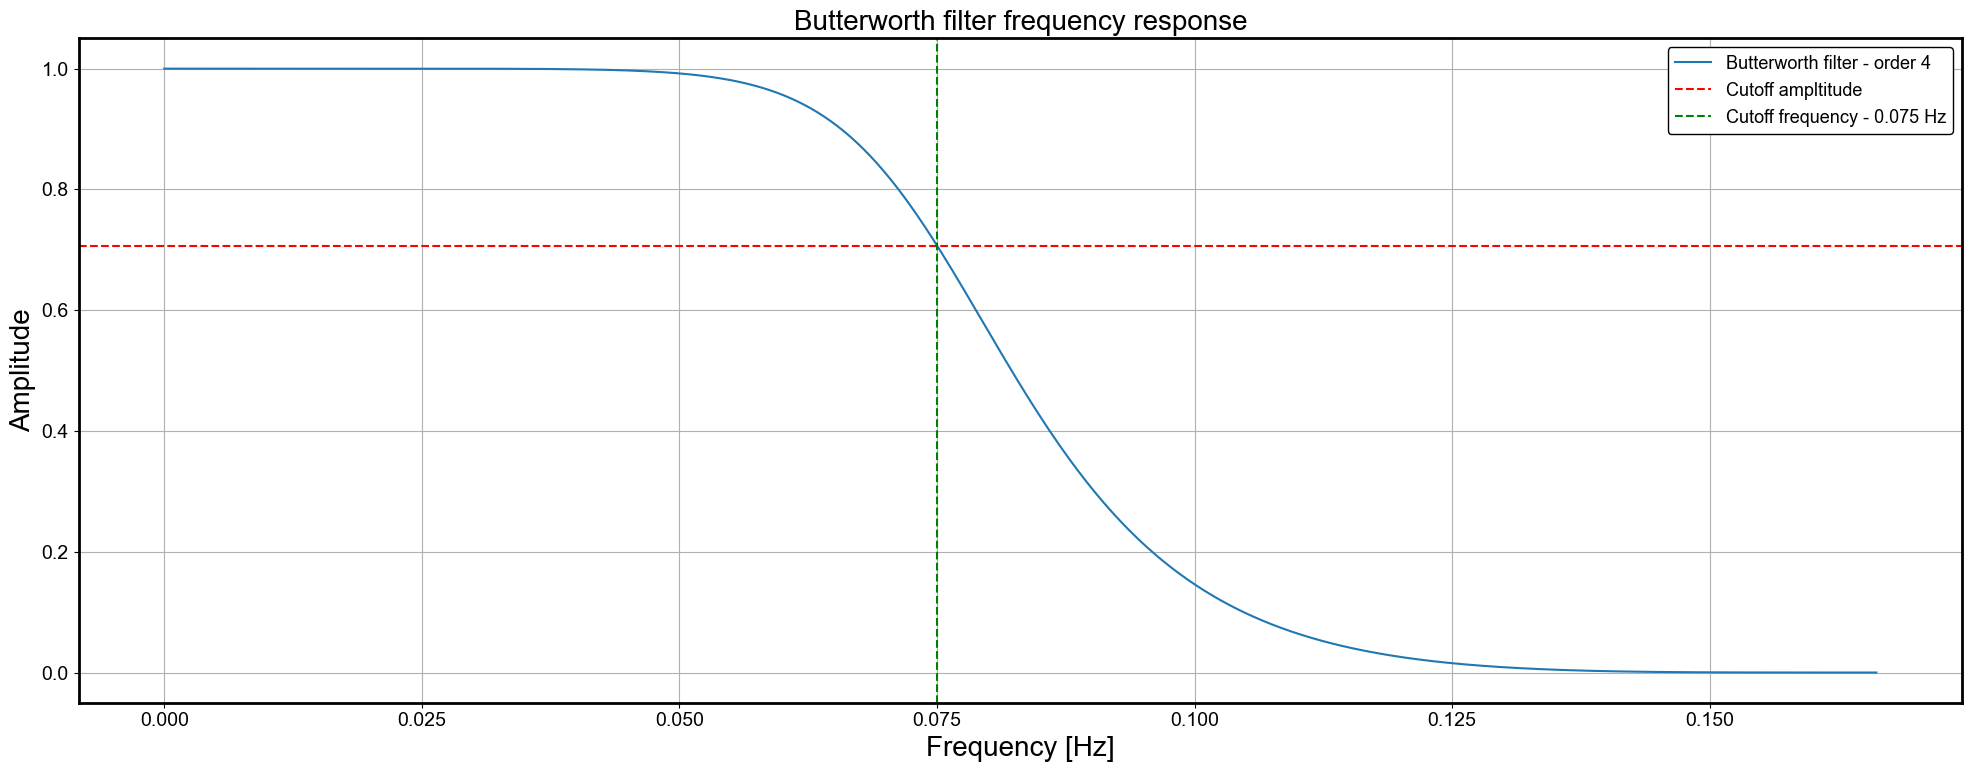

In [17]:
#%pylab

b,a = butterworth_filter(order=4, cutoff=0.075,  fs=1/(dt_list[0]), btype='lowpass', plot=True)

The cutoff frequency coincides with the amplitude of 0.707 or -3dB. By adjusting the order of the filter, the user can define how fast the frequency response goes from amplitude 1 to amplitude 0

In [18]:
df_butter_filtered = apply_butterfilter_df(df=df_filtered, order=4, cutoff=0.075, fs=1/(dt_list[0]), btype='lowpass')

100%|██████████| 3/3 [00:00<00:00, 1504.23it/s]


In [19]:
%pylab

fig, ax = compare_filtered_signals(df_filtered, df_butter_filtered,columns=['x','y','z'],legend=sensor_id_names[0], nrows=3, ncols=1, figsize=(15, 15))

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


C:\Users\arthu\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['fft2', 'ifft', 'fft', 'ifft2']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Checking the FFT of the Butterworth filtered signal

In [23]:
df_butter_filtered = pd.DataFrame(df_butter_filtered).T
df_butter_filtered.columns = [['x','y','z']]
df_butter_filtered

,x,y,z
0,-0.966137,-0.101794,0.008847
1,-0.971043,-0.131856,0.016874
2,-0.961685,-0.134371,0.038593
3,-0.949906,-0.108578,0.058480
4,-0.958637,-0.076901,0.051301
...,...,...,...
4975,-0.982835,0.058682,0.056973
4976,-1.021149,0.051893,0.035335
4977,-1.047083,0.011166,0.002198
4978,-1.044406,-0.039316,-0.009223


In [26]:
fig,ax, _ = plot_FFT(df=df_butter_filtered, dt=dt_list[0], nrows=3, ncols=1, subset=df_butter_filtered.columns, legend=sensor_id_names[0], figsize=(20, 8), plot_filtered=False)

From the above plot, all frequencies above the butterworth cutoff frequency has been removed